In [1]:
# Data handling
import pandas as pd
import numpy as np
import data_prep  # ! make sure that the files are in the same folder

# check computation time
import time

# Modelling
from sklearn.ensemble import RandomForestClassifier

# Feature importance
from sklearn.inspection import permutation_importance

# Hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Performance measures
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, \
    explained_variance_score, max_error

# Prediction visualisation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Has to be last due to overlapping functions from other packages

start_time_total = time.time()
start_time = time.time()
# Run the model
import fire_variable

elapsed_time = time.time() - start_time

print(f"\n Elapsed time to run simulation model: {elapsed_time:.3f} seconds")



# Assign dynamic features ---- array has length of (timesteps) x ( all pixels ) x (all simulated versions)
firedata = fire_variable.fire_array
areafire = fire_variable.Area_fire_array


#Retrieve size of frame and timesteps
horizontal_pixels  = fire_variable.horizontal_pixels
vertical_pixels = fire_variable.vertical_pixels
timesteps = fire_variable.timesteps

# Retrieve the list and the length of the list of variables used to run the different simulations
from fire_variable import variable_list
list_of_variables_for_simulation = variable_list
# print(list_of_variables_for_simulation)
number_of_training_simulations = len(list_of_variables_for_simulation)


# Assign feature of interest to 'data'
data = firedata

# Assign static features ---- array has length of 1x( all pixels ) x (all simulated versions)
dem = fire_variable.dem_array
# Repeat Static drivers for each timestep
dem = np.repeat(dem, timesteps)

list_data = np.array_split(data, number_of_training_simulations)
list_dem = np.array_split(dem, number_of_training_simulations)

list_driver_names = ['dem']

dfs = [None] * number_of_training_simulations
length_one_simulation = timesteps*vertical_pixels*horizontal_pixels
# Add drivers as features
neighbour = True

for iiii in range(number_of_training_simulations):
    print(iiii)

    if not neighbour:
        dfs[iiii] = data_prep.only_y_label(data=list_data[iiii],
                                                horizontal_pixels=horizontal_pixels,
                                                vertical_pixels=vertical_pixels,
                                                multiplesteps =False,
                                                print_true= False)
    if neighbour:
        dfs[iiii] = data_prep.neighbour_as_feature(data=list_data[iiii],
                                                horizontal_pixels=horizontal_pixels,
                                                vertical_pixels=vertical_pixels,
                                                multiplesteps=False,
                                                print_true= False)

    list_drivers = [list_dem[iiii]]

     # Add drivers at each timestep and each pixel to the dataframe
    for _ in range(len(list_drivers)):
        driver = list_drivers[_]
        name = list_driver_names[_]

        # Add driver at each timestep and each pixel to the dataframe
        dfs[iiii] = data_prep.driver_as_feature(df=dfs[iiii],
                                         driver=driver, driver_name=name,
                                         horizontal_pixels=horizontal_pixels,
                                         vertical_pixels=vertical_pixels,
                                         multiplesteps=False,
                                         print_true= False)

    # Add variable rate as feature
    dfs[iiii] = data_prep.VARIABLE_rate_as_feature(df= dfs[iiii],
                                                   variable_rate=list_of_variables_for_simulation[iiii],
                                                   variable_rate_name='Spread_rate',
                                                   horizontal_pixels=horizontal_pixels,
                                                   vertical_pixels=vertical_pixels,
                                                   multiplesteps=False,
                                                   print_true= False)

# Concatenate all dfs
df = pd.concat(dfs)

# Name features and labels
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Extract feature names for later processing
colnames = list(df.columns.values.tolist())
feature_names = colnames[:-1]
label_name = colnames[-1]

# Check data prep
print(feature_names)
print(features.shape)
print(label_name)
print(labels.shape)
print(number_of_training_simulations*horizontal_pixels*vertical_pixels*timesteps-(number_of_training_simulations*horizontal_pixels*vertical_pixels*2))

if labels.shape[0] == number_of_training_simulations*horizontal_pixels*vertical_pixels*timesteps-(number_of_training_simulations*horizontal_pixels*vertical_pixels*2):
    print('correct')
else:
    print('CHECK DATA PREP')

 
 Alpha_[0.2]_R_0.01

.................................................................................................... 
 Alpha_[0.2]_R_0.01

....................................................................................................
 Elapsed time to run simulation model: 44.235 seconds
0


ValueError: cannot set using a slice indexer with a different length than the value

In [3]:

length_one_simulation = timesteps*vertical_pixels*horizontal_pixels
one_time_step = horizontal_pixels*vertical_pixels

# Split at last timestep to predict last timestep
X_train = features.iloc[:-(length_one_simulation), :]
y_train = labels.iloc[:-(length_one_simulation)]

# The test set only contains the first initialised values for the simulation. The rest is predicted
X_test = features.iloc[-(length_one_simulation):(-(length_one_simulation)+one_time_step), :]

# Since we want to predict the entire simulation we do not have a set ylabel. Perhaps later construct y_label from all following simulated steps. But time series of important points generates a better view of the performance
y_test =  labels.iloc[-(length_one_simulation)+one_time_step:]

# Check train/test
print('X_train ', X_train.shape) #training features
print('Y_train ', y_train.shape) #training labels

print('X_test (only 1st step of last simulation)', X_test.shape) #testing features
print('Y_test (multiplestep Y>>X, complete simulation)', y_test.shape) #testing labels


X_train  (8640000, 11)
Y_train  (8640000,)
X_test (only 1st step of last simulation) (90000, 11)
Y_test (multiplestep Y>>X, complete simulation) (8910000,)


In [4]:

optimise_model_true = False

if optimise_model_true:
    # Altogether, there are many possible settings.
    # However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

    from sklearn.model_selection import RandomizedSearchCV

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=8)]
    # Number of features to consider at every split
    max_features = [1.0, 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 200, num=10)]

    # Minimum number of samples required to split a node
    min_samples_split = [2, 4, 6]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [4, 8, 16]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()

    # Random search of parameters, using 3 fold cross validation,

    rf_random = RandomizedSearchCV(estimator=rf,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   cv=3,
                                   verbose=4,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='explained_variance')

    # Fit the random search model
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)

else:
    # fit the model
    start_time_fitting = time.time()
    rf = RandomForestClassifier(max_features=100, max_depth=100, verbose=True)
    rf.fit(X_train, y_train)
    elapsed_time = time.time() - start_time_fitting
    print(f"\n Elapsed time to fit the model: {elapsed_time:.3f} seconds")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 Elapsed time to fit the model: 244.105 seconds


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished


In [5]:

# Predict one complete simulation on unseen variable
list_drivers_once = [list_dem[0]]


# -1 timestep due to removed last timesteps to avoid NaN's in Labels
steps = timesteps-1

# Initialise for saving predictions for animation and performance measures, respectively.
framed_predictions = pd.DataFrame()
array_predictions = np.empty(0)
list_each_prediction = [None] *steps

#Choose the initial starting state of the model as the Test set
X_test_multiple = X_train.iloc[:(horizontal_pixels*vertical_pixels),:]

In [6]:

    # - Make predictions
    # - Save prediction
    # - Set prediction as new input
    #
    # - Add static and dynamic drivers to new input
    array_area_pred = np.empty(0)
    last_pixel_driver = 0
    for _ in range(steps):
        # print(_)
        # Prediction step
        y_pred_rf = rf.predict(X_test_multiple)

        # Save the solution as a dataframe of pixels
        # For animation
        projected_prediction = pd.DataFrame(np.reshape(y_pred_rf,(int(vertical_pixels),int(horizontal_pixels))))
        framed_predictions = pd.concat([framed_predictions, projected_prediction], axis=0)

        # For evaluating AREA growth timeseries
        array_area_pred = np.append(array_area_pred, len(y_pred_rf[y_pred_rf == 1]))

        # For MSE map
        list_each_prediction[_] = projected_prediction

        # For performance measures
        array_predictions = np.append(array_predictions, y_pred_rf)

        # Create the new test set for next prediction
        if not neighbour:
            new_state = data_prep.only_y_label(y_pred_rf.reshape(-1,1),
                                                       horizontal_pixels,
                                                       vertical_pixels,
                                                       multiplesteps=True,
                                                       print_true= False)
        if neighbour:
            new_state = data_prep.neighbour_as_feature(y_pred_rf.reshape(-1,1),
                                                       horizontal_pixels,
                                                       vertical_pixels,
                                                       multiplesteps=True,
                                                       print_true= False)
        # Add the drivers at that timestep
        first_pixel_driver = last_pixel_driver
        last_pixel_driver = first_pixel_driver + (vertical_pixels*horizontal_pixels)
        for __ in range(len(list_drivers_once)):
            driver = list_drivers_once[__]
            name = list_driver_names[__]
            new_state = data_prep.driver_as_feature(df = new_state,
                                                    driver=driver[first_pixel_driver:(last_pixel_driver)],
                                                    driver_name= name,
                                                    horizontal_pixels=horizontal_pixels,
                                                    vertical_pixels=vertical_pixels,
                                                    multiplesteps=True)

        # Add variable rate as feature
        df = data_prep.VARIABLE_rate_as_feature(df = new_state,
                                                variable_rate= list_of_variables_for_simulation[-1],
                                                variable_rate_name = 'Spread_rate',
                                                horizontal_pixels=horizontal_pixels,
                                                vertical_pixels=vertical_pixels,
                                                multiplesteps=True)


        # remove the Y_label-- y_label only used for training
        X_test_multiple = new_state.iloc[:, :-1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

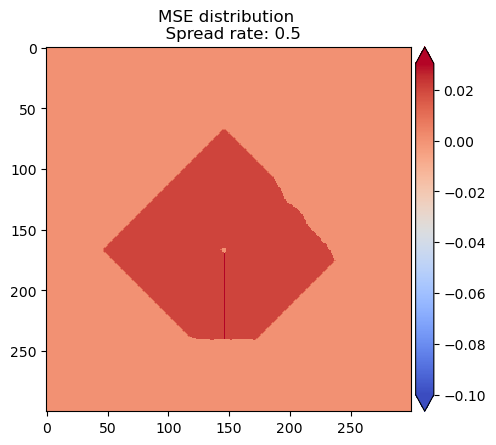

In [7]:

    # Generate results:
    # MSE_map: Mean of each pixel averaged over all timesteps

    # Reshape y_test for MSE. Same shape as framed predictions. vertical x horziontal with next timestep below.
    framed_y_test = pd.DataFrame()
    first_pixel_y_test = 0
    y_test = pd.Series(y_test)
    list_y_test_ = [None] * steps

    for _ in range(steps):

        last_pixel_y_test = one_time_step*(_+1)
        # print("last pixel = ",last_pixel_y_test)
        # print("first pixel = ", first_pixel_y_test)
        # print('length y_test = ', len(y_test))
        # print('length y_test[i:j] = ', len(y_test[first_pixel_y_test:last_pixel_y_test]))
        projected_y_test = pd.DataFrame(y_test[first_pixel_y_test:last_pixel_y_test].values.reshape((int(vertical_pixels),int(horizontal_pixels))))
        list_y_test_[_] = projected_y_test
        framed_y_test = pd.concat([framed_y_test, projected_y_test], axis=0)

        first_pixel_y_test = last_pixel_y_test

    squared_difference = [None] * steps
    test_concat = pd.DataFrame()
    for __ in range(steps):
        # print(__)
        squared_difference[__] = (list_each_prediction[__] - list_y_test_[__])**2

    dfs = squared_difference
    MSE_map = pd.concat([each.stack() for each in dfs],axis=1)\
                 .apply(lambda x:x.mean(),axis=1)\
                 .unstack()


    fig, ax = plt.subplots(figsize=(5,5))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cmap = cm.coolwarm
    im = ax.imshow(MSE_map, interpolation='nearest', cmap=cmap, vmin=MSE_map.to_numpy().max(), vmax=MSE_map.to_numpy().min())
    ax.set_title(f'MSE distribution \n  Spread rate: {list_of_variables_for_simulation[-1]}')
    fig.colorbar(im,cax=cax, orientation='vertical', extend = 'both')

    plt.plot()
    plt.savefig(f'Results/with_neighbours_fire_MSE_map_rate_{list_of_variables_for_simulation[-1]}.png')
    plt.show()
    plt.close()

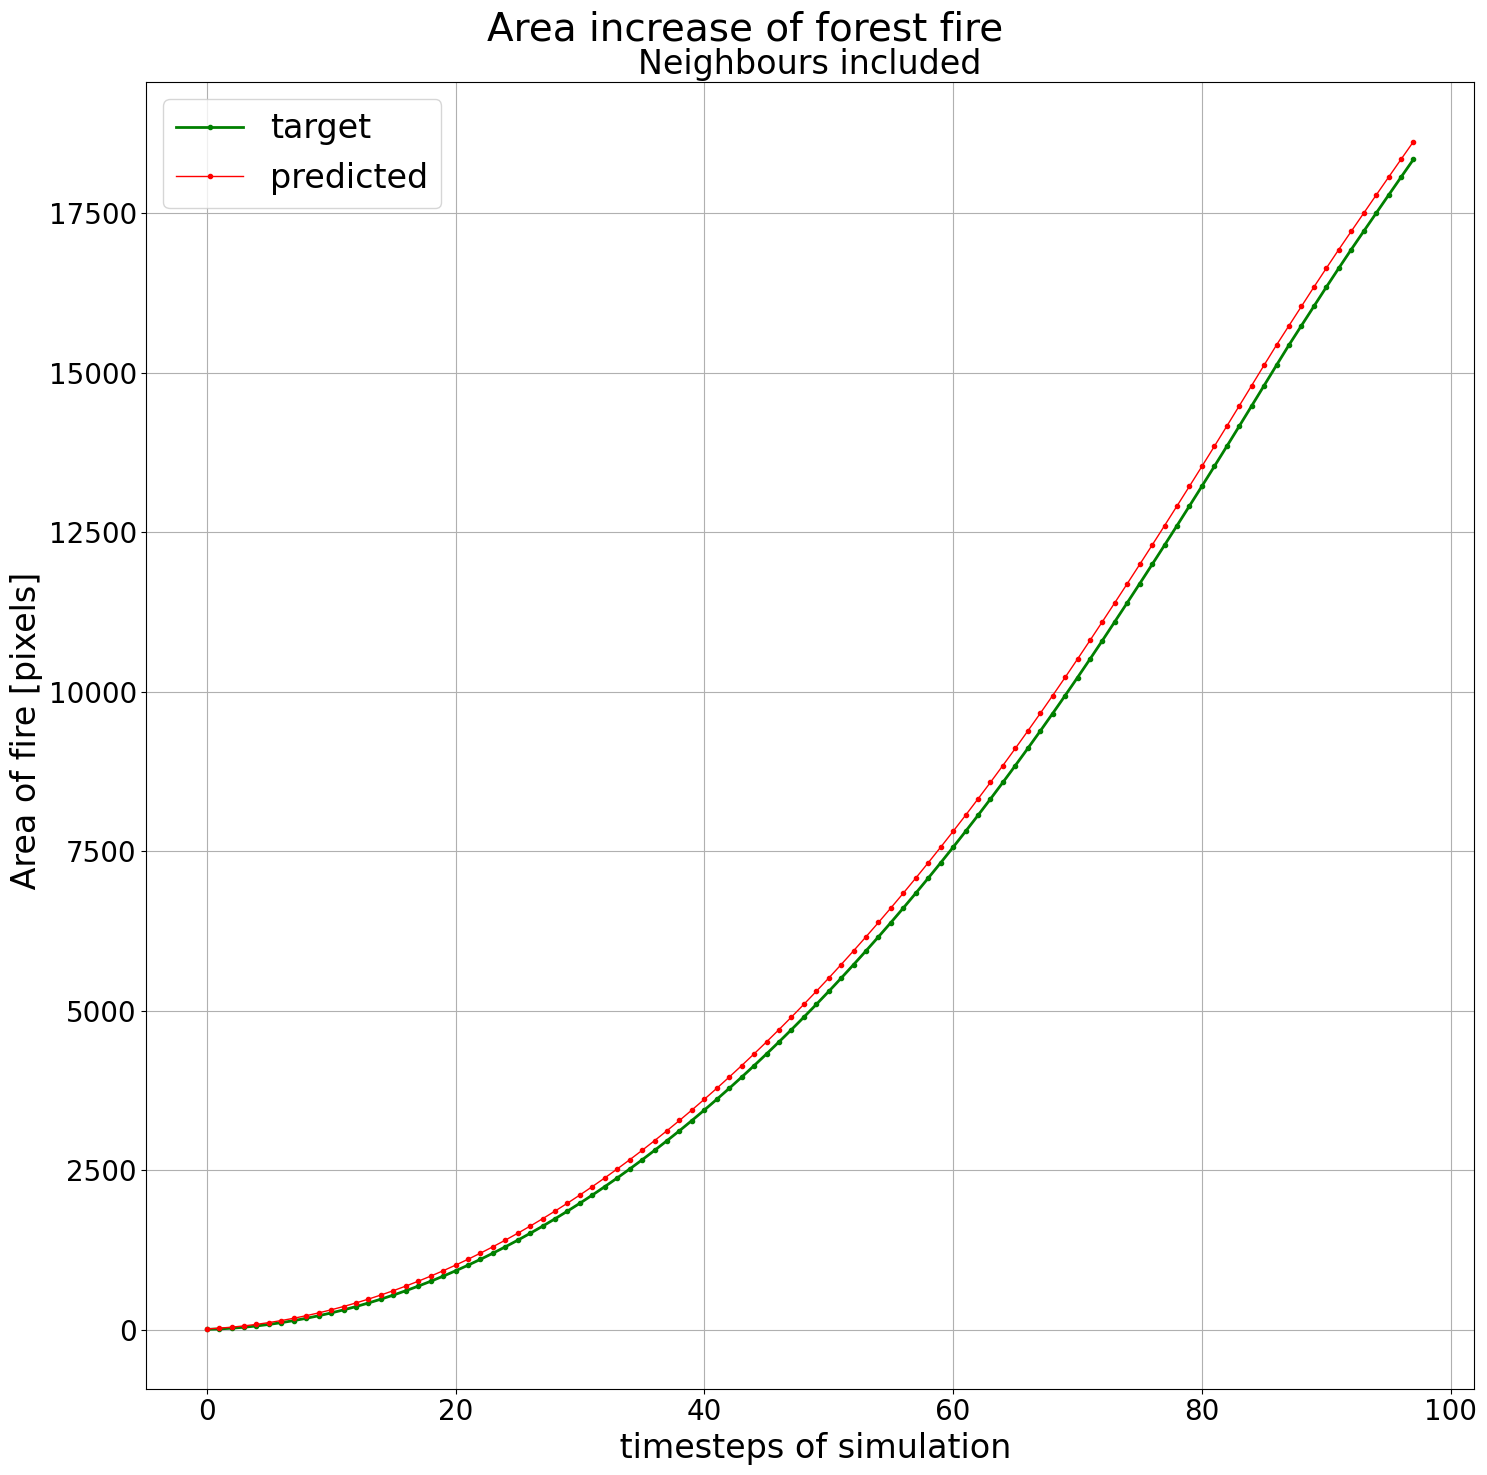

Elapsed time to run whole script: 300.920 seconds


In [8]:

    # Visualise predictions

    # Extract the timeseries data of these points from the simulated and emulated data
    plot_xvalues = timesteps-2

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    fig.suptitle('Area increase of forest fire', fontsize=28)

    #---- point 1
    ax.plot(range(plot_xvalues), areafire[:plot_xvalues], '.-', color = 'green', linewidth= 2)
    ax.plot(range(plot_xvalues), array_area_pred[:plot_xvalues], '.-', color = 'red', linewidth= 1.0)

    ax.set_title('Neighbours included', fontsize = 24)
    ax.set_ylabel(' Area of fire [pixels]', fontsize = 24)
    ax.set_xlabel(' timesteps of simulation', fontsize = 24)
    ax.legend(['target', 'predicted'],fontsize= 24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    ax.grid()


    fig.tight_layout()
    # plt.subplot_tool()
    plt.plot()
    plt.savefig(f'Results/with_neighbours_fire_timeseries_rate_{list_of_variables_for_simulation[-1]}.png')
    plt.show()
    plt.close()


    elapsed_time = time.time() - start_time_total

    print(f"Elapsed time to run whole script: {elapsed_time:.3f} seconds")